# Michael Vazquez<br>Econ 570, Assignment 2<br>Link to code:

# Imports.

In [92]:
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import os

from IPython import get_ipython
from IPython.display import Image, display


# Functions.

## Summary statistics.

In [93]:
# Copy and pasted summary statistics from assignment 1. Should create a module for functions that
# will be re-used throught this course.
def summary_statistics(df: pd.DataFrame, stats_col_name: str, date_col_name: str) -> dict:

    """
    Use this function to find the summary statistics discussed in the slides, "Lecture2_SP2026.pdf".

    Parameters
    ----------
    df : pd.DataFrame
        Passed DataFrame containing stats_col_name and date_col_name.
    stats_col_name : str
        Column on which to calculate the summary statistics.
    date_col_name : str
        Column on which to find min and max date.

    Returns
    -------
    dict
        Key 'df_summary_stats' contains the DataFrame of summary statistics.
        Key 'min_date' is the minimum of date_col_name.
        Key 'max_date' is the maximum of date_col_name.

    """

    df_summary_stats = pd.DataFrame(
    data={
        'mean': [df[stats_col_name].mean()],
        'median': [df[stats_col_name].median()],
        'var': [df[stats_col_name].var()],
        'std_dev': [df[stats_col_name].std()],
        'skewness': [df[stats_col_name].skew()],
        'kurtosis': [df[stats_col_name].kurtosis()]
        }
    ).T\
    .reset_index(names='statistic')\
    .rename(columns={0: 'value'}, errors='raise')\
    .round(4)

    return {
        'df_summary_stats': df_summary_stats,
        'min_date': df[date_col_name].min(),
        'max_date': df[date_col_name].max()
        }


## Forecasting models.

In [94]:
def create_forecasting_models(
    df,
    h,
    date_col="date",
    y_col="price",
    holdout_start="2011-01-01"
):
    """
    Create forecasting models of all four models in assignment 2 using the passed df.
    Forecast errors are computed as actual minus forecast.
    """

    df = df.dropna(subset=[date_col, y_col])\
        .sort_values(date_col)\
        .reset_index(drop=True)

    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    holdout_start = pd.Timestamp(holdout_start)

    # Default argument y_col='price'. y variable here better matches the model formulas
    # in the assignment.
    y = df[y_col].copy()
    y_shift = y.shift(-h)

    # Per the assignment's naive mean model details, "is the mean of the data from the start
    # of the sample until period t. pandas expanding and then taking the mean handles this."
    # https://pandas.pydata.org/pandas-docs/version/2.2/reference/api/pandas.Series.expanding.html
    # f_ to denote forecast, ie f_mean forecasting model naive mean model.
    f_mean = y.expanding().mean()
    # Naive drift model 2a. has delta = (y_t - y_{t-1}).
    f_drift_1  = y + (h * (y - y.shift(1)))
    # Naive drift model 2b. has delta_t = (1/12) * (y_t - y_{t-12})
    f_drift_12 = y + h * ((1 / 12) * (y - y.shift(12)))
    # Seasonal naive model, y_{t+h-12}.
    f_seasonal = y.shift(12 - h)

    df_forecast = pd.DataFrame({
        "t": y.index,
        "t_plus_h": y.index + pd.DateOffset(months=h),
        "y_shift": y_shift,
        "f_mean": f_mean,
        "f_drift_1": f_drift_1,
        "f_drift_12": f_drift_12,
        "f_seasonal": f_seasonal,
    })

    # The y_{t+h} term must be in the sample.
    df_forecast = df_forecast.loc[(df_forecast["y_shift"].notna()), :]

    # Align all timeframes using the holdout_start. This avoids comparing jan last
    # year to feb this year, etc.
    df_forecast = df_forecast.loc[df_forecast["t_plus_h"] >= holdout_start]

    # Calculate the forecast errors, actual minus forecast, of all four models.
    for col in ["f_mean", "f_drift_1", "f_drift_12", "f_seasonal"]:
        df_forecast["e_" + col[2:]] = df_forecast["y_shift"] - df_forecast[col]

    df_forecast = df_forecast.reset_index(drop=True)

    # The minimum date here needs to be where the holdout sample starts.
    assert df_forecast["t_plus_h"].min() == holdout_start, \
        f"Evaluation window starts {df_forecast['t_plus_h'].min()}, expected {holdout_start}"

    # t_plus_h should be approximately h months after t, if dates were aligned correctly
    # in the holdout_start filter.
    offsets = (df_forecast["t_plus_h"] - df_forecast["t"]).dt.days
    assert offsets.between(28 * h, 31 * h).all(), \
        "t_plus_h is not approximately h months after t"
    
    # No sample look ahead. t must be strictly before t_plus_h
    assert (df_forecast["t"] < df_forecast["t_plus_h"]).all(), \
        "Look-ahead detected: t >= t_plus_h"

    return df_forecast


# Read the S&P 500 file.

In [95]:
# We only need the date and price for this assignment.
df_sp = pd.read_excel(
    'Assignment 2 - SP500 data.xlsx',
    usecols=['Date', 'Price'],
    dtype={'Price': 'float64'},
    parse_dates=['Date']
)
# Clean up column names and ensure date asc order.
df_sp = df_sp.rename(columns={col: col.lower() for col in df_sp.columns})\
    .sort_values(by=['date'])\
    .reset_index(drop=True)

print(df_sp.info())
print(f"df_sp shape: {df_sp.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    312 non-null    datetime64[ns]
 1   price   312 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 KB
None
df_sp shape: (312, 2)


## S&P 500 summary statistics, display some rows, and basic raw data plots.

In [96]:

sp_dict = summary_statistics(df_sp, 'price', 'date')
print("----------------------------")
for k, v in sp_dict.items():
    print(f"{k}:\n{v}\n----------------------------")

display(df_sp.sample(n=10))

----------------------------
df_summary_stats:
  statistic         value
0      mean  2.311854e+03
1    median  1.559300e+03
2       var  2.284445e+06
3   std_dev  1.511438e+03
4  skewness  1.322300e+00
5  kurtosis  8.533000e-01
----------------------------
min_date:
2000-03-01 00:00:00
----------------------------
max_date:
2026-02-01 00:00:00
----------------------------


,date,price
126,2010-09-01,1141.20
217,2018-04-01,2648.05
86,2007-05-01,1530.60
150,2012-09-01,1440.70
104,2008-11-01,896.20
70,2006-01-01,1280.10
157,2013-04-01,1597.60
204,2017-03-01,2362.72
187,2015-10-01,2079.36
129,2010-12-01,1257.60


<Axes: title={'center': 'Raw Data, S&P 500 Price Level vs Date'}, xlabel='date', ylabel='price'>

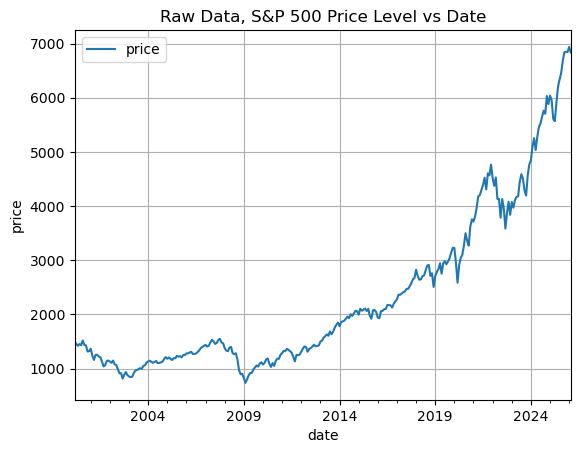

In [97]:
df_sp.set_index('date').plot(ylabel='price', title='Raw Data, S&P 500 Price Level vs Date', grid=True)

##### The raw price level data shows an upward trend over time, with dips around where we would expect, in 2008 and 2020. Given the strong growth over the past few years, forecasting models using historical references may not provide good predictions..

## Ensure no missing monthly data, as this would cause issues with the forecasting models.

In [98]:
assert pd.Series(pd.date_range(start=df_sp['date'].min(), end=df_sp['date'].max(), freq='MS')).equals(df_sp['date']),\
    "The S&P 500 data is missing at least one month."

# Question 1.0 - Price level forecasting.

In [ ]:
# Run the forecasting models on price levels for horizons h=1 and h=12.
df_fc1_price  = create_forecasting_models(df_sp, h=1)
df_fc12_price = create_forecasting_models(df_sp, h=12)

# These lists all must have same length. Will use to keep the models
# mapped to the same colors throughout the rest of this notebook.
error_cols = ['e_mean', 'e_drift_1', 'e_drift_12', 'e_seasonal']
forecast_cols = ['f_mean', 'f_drift_1', 'f_drift_12', 'f_seasonal']
model_labels = ['Naive Mean', 'Drift 1', 'Drift 12', 'Seasonal Naive']
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

print(f"h=1 rows: {(df_fc1_price.shape[0])}, from {df_fc1_price['t_plus_h'].min().strftime('%Y-%m')} to {df_fc1_price['t_plus_h'].max().strftime('%Y-%m')}")
print(f"h=12 rows: {df_fc12_price.shape[0]}, from {df_fc12_price['t_plus_h'].min().strftime('%Y-%m')} to {df_fc12_price['t_plus_h'].max().strftime('%Y-%m')}")

h=1 rows: 182, from 2011-01 to 2026-02
h=12 rows: 182, from 2011-01 to 2026-02


## 1.1 - MSFE of price levels.

In [100]:
# Compute MSFE for each model at both horizons.
df_msfe_price_level = pd.DataFrame({
    'model':    model_labels,
    'msfe_h1':  [df_fc1_price[e].pow(2).mean()  for e in error_cols],
    'msfe_h12': [df_fc12_price[e].pow(2).mean() for e in error_cols],
}).set_index('model')

display(df_msfe_price_level.style
    .format('{:,.2f}')
    .highlight_min(subset=['msfe_h1'],  color='lightgreen')
    .highlight_max(subset=['msfe_h1'], color='red')
    .highlight_min(subset=['msfe_h12'], color='lightgreen')
    .highlight_max(subset=['msfe_h12'], color='red')
    .set_caption('MSFE - Price Levels')
)
print('Green --> Best model in the horizon column.')
print('Red --> Worst model in the horizon column.')
best_h1  = df_msfe_price_level['msfe_h1'].idxmin()
best_h12 = df_msfe_price_level['msfe_h12'].idxmin()
print(f"Best model h=1: {best_h1}")
print(f"Best model h=12: {best_h12}")

,msfe_h1,msfe_h12
model,,
Naive Mean,"3,892,323.92","4,184,778.37"
Drift 1,"41,421.03","2,608,879.49"
Drift 12,"20,157.48","382,239.48"
Seasonal Naive,"309,458.22","309,458.22"


Green --> Best model in the horizon column.
Red --> Worst model in the horizon column.
Best model h=1: Drift 12
Best model h=12: Seasonal Naive


##### At h=1, **Drift 12** has the lowest MSFE and thus is the best of the four models in predicting the increase in price level over time. At h=12, **Seasonal Naive** provides the best predictions of the four models, as it takes a year over year forecasting approach and thus encompasses any seasonal trends in price level. Naive Mean performs the worst at both horizons because the long run historical average is well below the price level in recent years.

##### Note: Seasonal Naive has the same MSFE at h=1 and h=12. This is caused by the model's definition, $\hat{y}_{t+h} = y_{t+h-12}$. The error at any month start date $T$ is always $y_T - y_{T-12}$, regardless of h. Both horizons produce the exact same set of errors, and therefore the same MSFE.

## 1.2 - Forecasts vs. actuals, price levels.

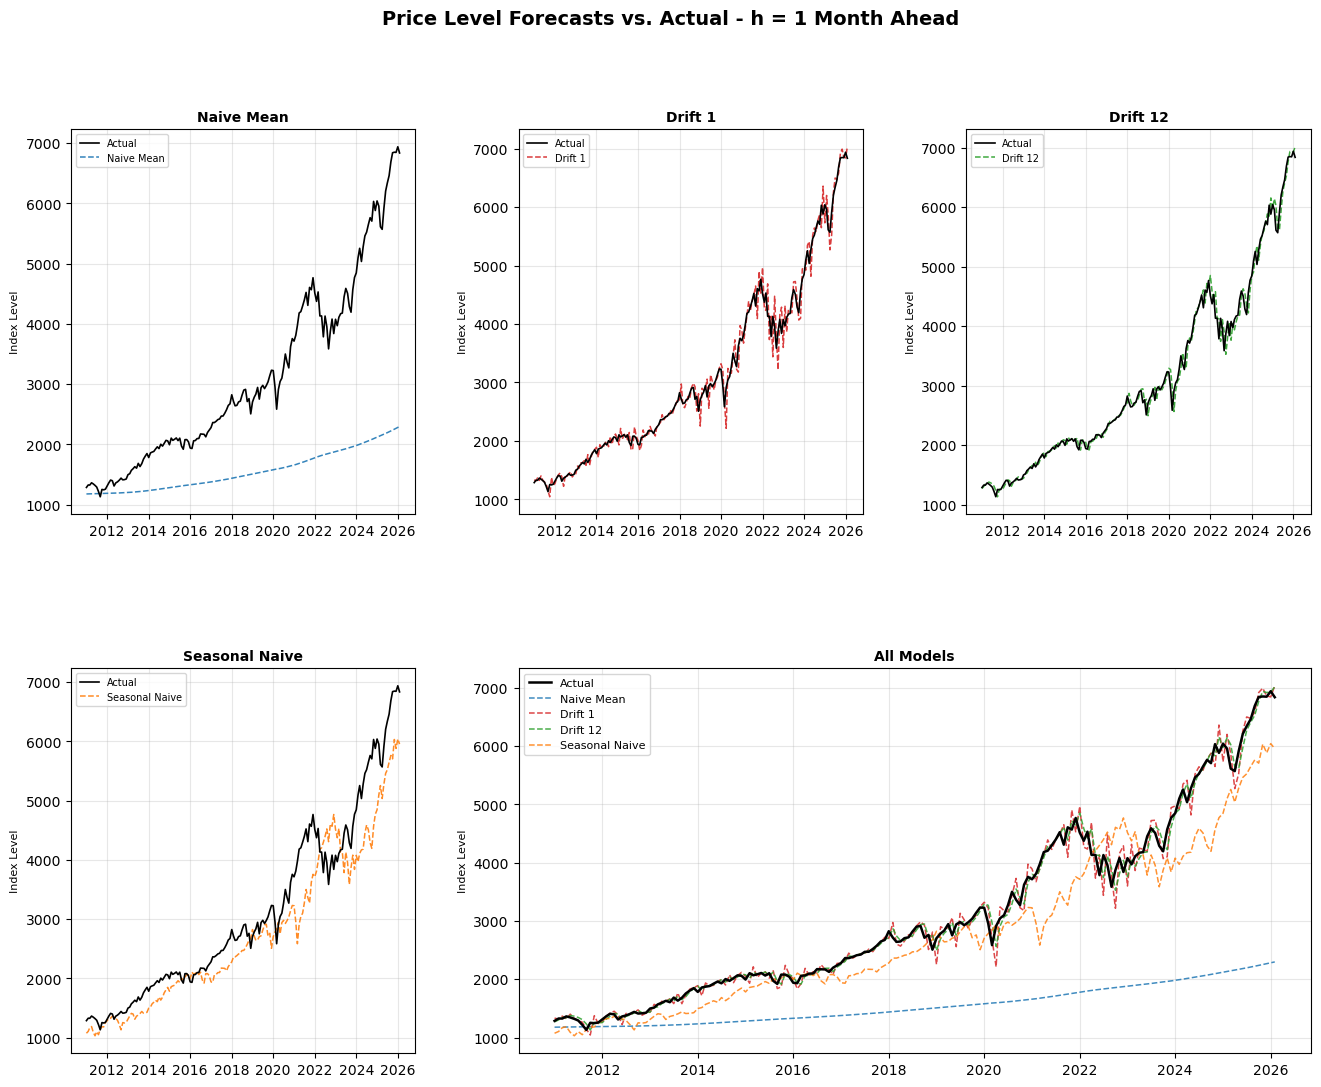

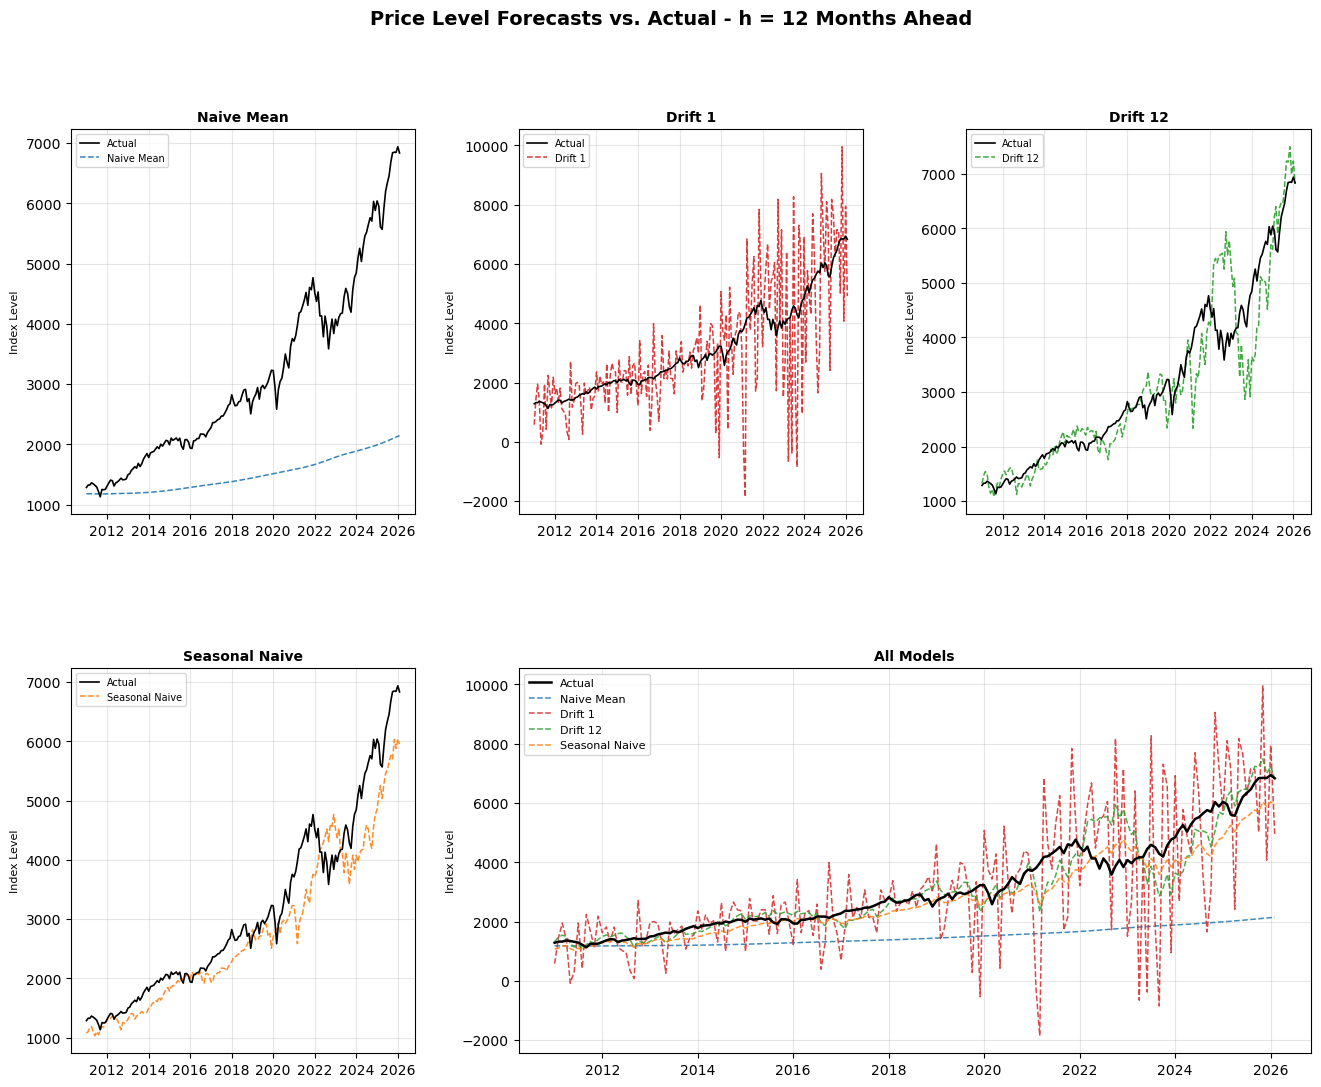

In [101]:
for df_fc, h_label, y_label in [
    (df_fc1_price,  'h = 1 Month Ahead',  'Index Level'),
    (df_fc12_price, 'h = 12 Months Ahead','Index Level'),
]:
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(f'Price Level Forecasts vs. Actual - {h_label}', fontsize=14, fontweight='bold')

    # Create a 2 x 3 grid, with spacing for the 5th plot.
    gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)
    individual_axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, 0]),
    ]
    ax_combined = fig.add_subplot(gs[1, 1:])

    # Plot each forecast vs actually on its own plot. A plot of all 4 models
    # and the actuals gets messy.
    # Provide the messy plot anyway, all 5 curves.
    for ax, col, lbl, c in zip(individual_axes, forecast_cols, model_labels, colors):
        ax.plot(df_fc['t_plus_h'], df_fc['y_shift'], color='black', linewidth=1.2,
                label='Actual', zorder=5)
        ax.plot(df_fc['t_plus_h'], df_fc[col], color=c, linestyle='--', linewidth=1.1,
                label=lbl, alpha=0.9)
        ax.set_title(lbl, fontsize=10, fontweight='bold')
        ax.set_ylabel(y_label, fontsize=8)
        ax.legend(fontsize=7)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.grid(True, alpha=0.3)

    
    ax_combined.plot(df_fc['t_plus_h'], df_fc['y_shift'], color='black', linewidth=1.8,
                     label='Actual', zorder=5)
    for col, lbl, c in zip(forecast_cols, model_labels, colors):
        ax_combined.plot(df_fc['t_plus_h'], df_fc[col], color=c, linestyle='--',
                         linewidth=1.1, label=lbl, alpha=0.85)
    ax_combined.set_title('All Models', fontsize=10, fontweight='bold')
    ax_combined.set_ylabel(y_label, fontsize=8)
    ax_combined.legend(fontsize=8, loc='upper left')
    ax_combined.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax_combined.grid(True, alpha=0.3)

    plt.show()

## 1.3 - Forecast errors, price levels.

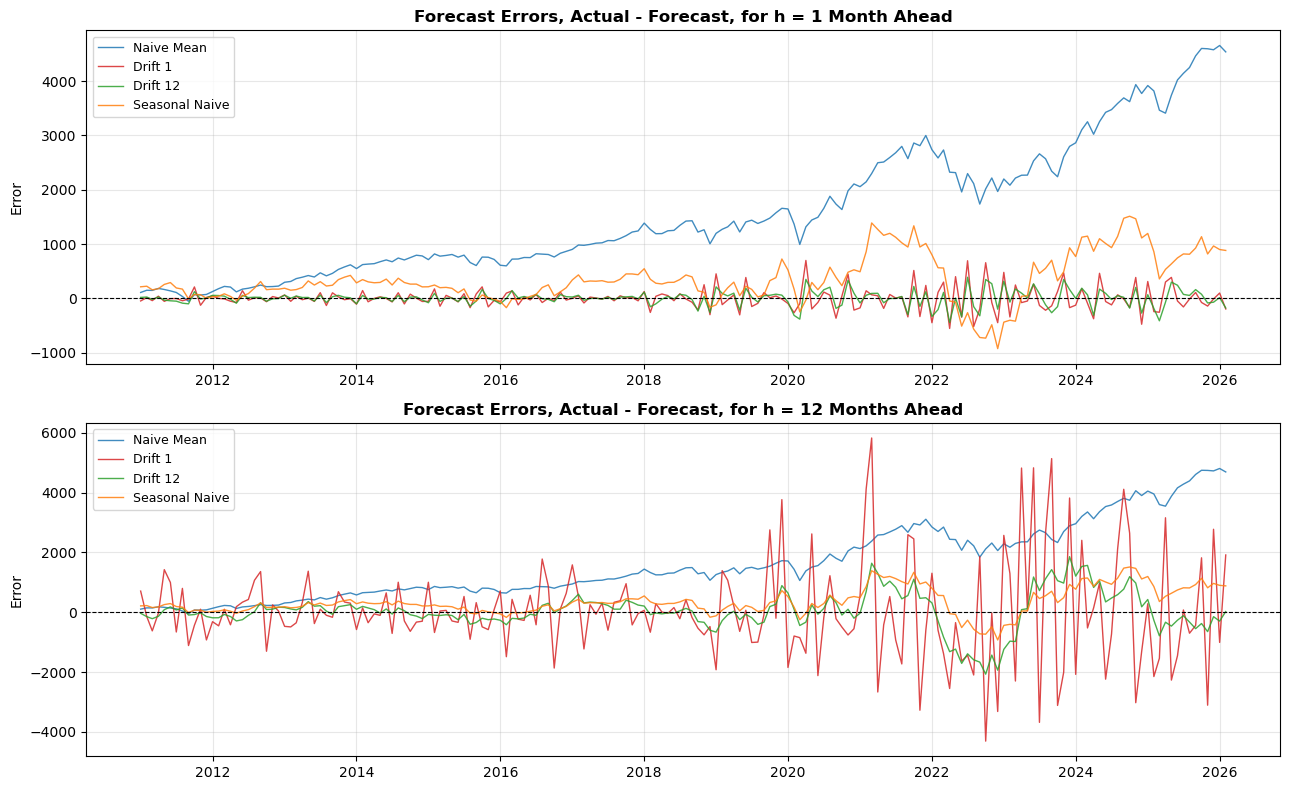

In [102]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=False)

for ax, df_fc, h_label in zip(axes,
                               [df_fc1_price, df_fc12_price],
                               ['h = 1 Month Ahead', 'h = 12 Months Ahead']):
    for col, lbl, c in zip(error_cols, model_labels, colors):
        ax.plot(df_fc['t_plus_h'], df_fc[col], linewidth=1.0, color=c, label=lbl, alpha=0.85)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(f'Forecast Errors, Actual - Forecast, for {h_label}', fontweight='bold')
    ax.set_ylabel('Error')
    ax.legend(fontsize=9, loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Confirming results from Question 1.1
The Naive Mean error is large and trending upwards throughout the holdout period, confirming the results from the table in Question 1.1. For both horizons, Naive Mean model is the worst.

Drift 1 errors are highly volatile at h=12 since one month of price level data is used to predict 12 months ahead, thus creating the large spikes.

Drift 12 and Seasonal Naive track the actual price level more closely, with errors clustering near zero except for a few years after 2020, when the economy was impacted by covid. Looking at 2024 forward, the errors of these models appear to be getting closer to the zero line, as they were prior to 2020. This suggests that the Drift 12 and Seasonal Naive are good models in normal economic conditions, but do not handle economic shocks very well.

# Question 2.0 - Log return forecasting.

In [103]:
# Obtain monthly log returns as the first difference of log price.
df_sp['log_return'] = np.log(df_sp['price']).diff()
# df_ret because return is a reserved word and would get confusing.
df_ret = df_sp[['date', 'log_return']].dropna().reset_index(drop=True)


In [104]:
ret_dict = summary_statistics(df_ret, 'log_return', 'date')
print("----------------------------")
for k, v in ret_dict.items():
    print(f"{k}:\n{v}\n----------------------------")

display(df_sp.sample(n=10))

----------------------------
df_summary_stats:
  statistic   value
0      mean  0.0049
1    median  0.0112
2       var  0.0019
3   std_dev  0.0438
4  skewness -0.7117
5  kurtosis  1.2496
----------------------------
min_date:
2000-04-01 00:00:00
----------------------------
max_date:
2026-02-01 00:00:00
----------------------------


,date,price,log_return
12,2001-03-01,1160.30,-0.066352
113,2009-08-01,1020.60,0.032969
173,2014-08-01,2003.37,0.036964
203,2017-02-01,2363.64,0.036523
220,2018-07-01,2816.29,0.035388
239,2020-02-01,2954.22,-0.087860
99,2008-06-01,1280.00,-0.089898
119,2010-02-01,1104.50,0.028096
124,2010-07-01,1101.60,0.066525
59,2005-02-01,1203.60,0.018702


##### Log returns fluctuate around a small positive mean, unlike the price level series. The negative skewness shows that large negative returns  occur more often than large positive returns. The kurtosis value here tells us that extreme observations occur somewhat frequently in the data, representing extreme fluctuations in returns. With these properties and by in class discussions, the historical returns mean is a solid benchmark.

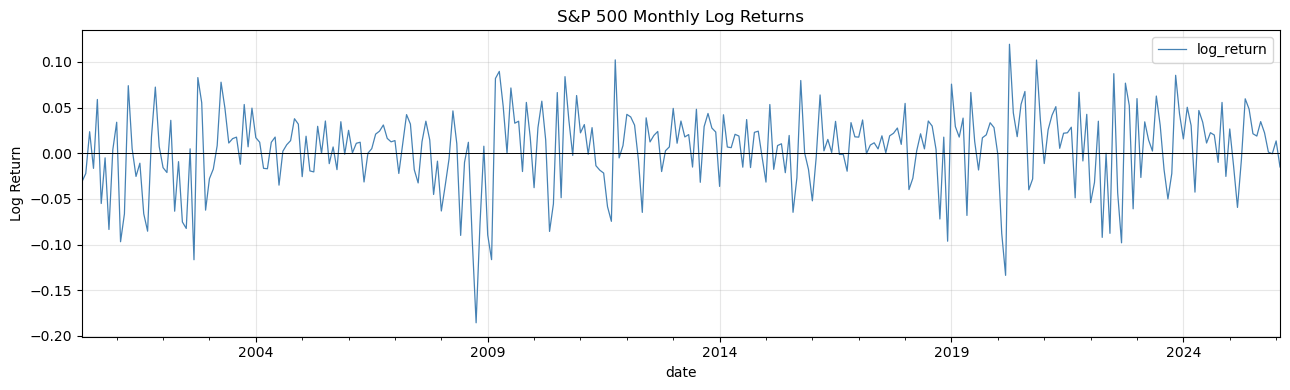

In [105]:
df_sp[['date', 'log_return']].set_index('date').dropna().plot(
    figsize=(13, 4),
    title='S&P 500 Monthly Log Returns',
    ylabel='Log Return',
    color='steelblue',
    linewidth=0.9
)
plt.axhline(0, color='black', linewidth=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.1 - MSFE, log returns.

In [106]:
# Run the forecasting models on log returns for h=1 and h=12.
df_fc1_ret  = create_forecasting_models(df_ret, h=1,  y_col='log_return')
df_fc12_ret = create_forecasting_models(df_ret, h=12, y_col='log_return')

df_msfe_ret = pd.DataFrame({
    'model':    model_labels,
    'msfe_h1':  [df_fc1_ret[e].pow(2).mean()  for e in error_cols],
    'msfe_h12': [df_fc12_ret[e].pow(2).mean() for e in error_cols],
}).set_index('model')

display(df_msfe_ret.style
    .format('{:.6f}')
    .highlight_min(subset=['msfe_h1'], color='lightgreen')
    .highlight_max(subset=['msfe_h1'], color='red')
    .highlight_min(subset=['msfe_h12'], color='lightgreen')
    .highlight_max(subset=['msfe_h12'], color='red')
    .set_caption('MSFE - Log Returns')
)
print('Green --> Best model in the horizon column.')
print('Red --> Worst model in the horizon column.')
best_h1  = df_msfe_ret['msfe_h1'].idxmin()
best_h12 = df_msfe_ret['msfe_h12'].idxmin()
print(f"Best model h=1:  {best_h1}")
print(f"Best model h=12: {best_h12}")

,msfe_h1,msfe_h12
model,,
Naive Mean,0.001672,0.001674
Drift 1,0.011102,0.628517
Drift 12,0.003992,0.010679
Seasonal Naive,0.003384,0.003384


Green --> Best model in the horizon column.
Red --> Worst model in the horizon column.
Best model h=1:  Naive Mean
Best model h=12: Naive Mean


#####
**Naive Mean** is the best model at both horizons, h=1 and h=12. For stationary returns with nearly zero autocorrelation, the historical mean is the theoretically correct benchmark, as it essentially states that next month's return will be about average, which is consistent with the Efficient Market Hypothesis.

Drift 1 at h=12 is by far the worst model in this table, as it because it predicts one month of returns 12 months forward, increasing the errors over every month.

Drift 12 and Seasonal Naive have higher MSFEs than Naive Mean because there is no persistent trend or seasonal pattern to reference in return data, per the Efficient Market Hypothesis.

**Note**: As with price levels, Seasonal Naive has the same MSFE at h=1 and h=12.

## 2.2 - Forecasts vs. actuals, log returns.

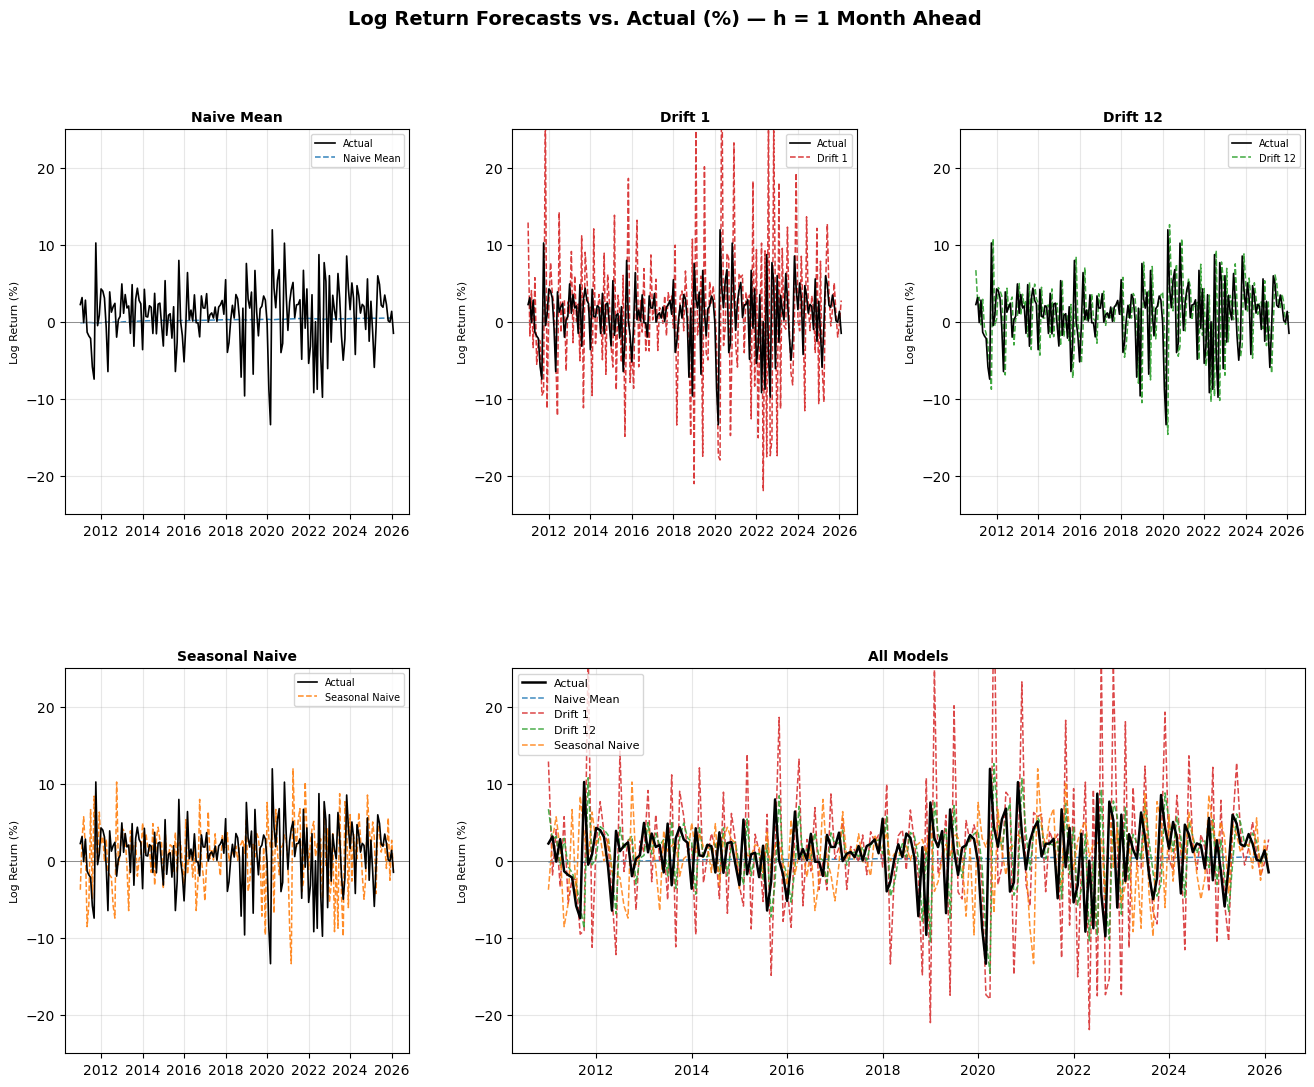

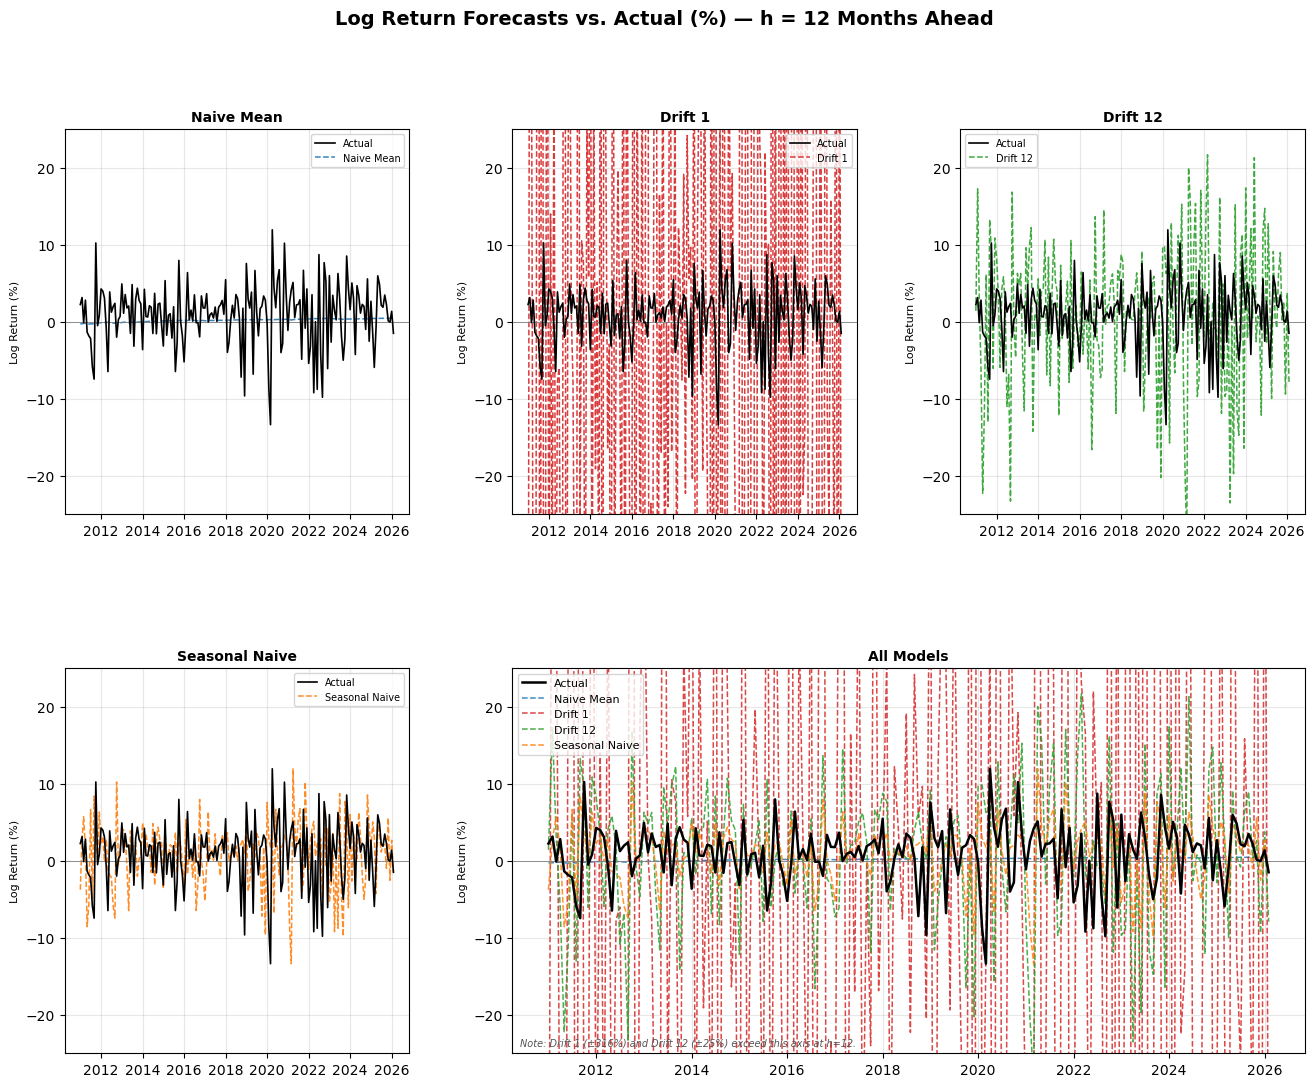

In [107]:
for df_fc, h_label, h_val in [
    (df_fc1_ret,  'h = 1 Month Ahead',  1),
    (df_fc12_ret, 'h = 12 Months Ahead',12),
]:
    y_lim = max(df_fc['y_shift'].abs().max() * 100 * 1.5, 25)

    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(f'Log Return Forecasts vs. Actual (%) — {h_label}', fontsize=14, fontweight='bold')

    gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)
    individual_axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, 0]),
    ]
    ax_combined = fig.add_subplot(gs[1, 1:])

    for ax, col, lbl, c in zip(individual_axes, forecast_cols, model_labels, colors):
        ax.plot(df_fc['t_plus_h'], df_fc['y_shift'] * 100, color='black', linewidth=1.2,
                label='Actual', zorder=5)
        ax.plot(df_fc['t_plus_h'], df_fc[col] * 100, color=c, linestyle='--',
                linewidth=1.1, label=lbl, alpha=0.9)
        ax.axhline(0, color='gray', linewidth=0.6)
        ax.set_ylim(-y_lim, y_lim)
        ax.set_title(lbl, fontsize=10, fontweight='bold')
        ax.set_ylabel('Log Return (%)', fontsize=8)
        ax.legend(fontsize=7)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.grid(True, alpha=0.3)

    ax_combined.plot(df_fc['t_plus_h'], df_fc['y_shift'] * 100, color='black',
                     linewidth=1.8, label='Actual', zorder=5)
    for col, lbl, c in zip(forecast_cols, model_labels, colors):
        ax_combined.plot(df_fc['t_plus_h'], df_fc[col] * 100, color=c, linestyle='--',
                         linewidth=1.1, label=lbl, alpha=0.85)
    ax_combined.axhline(0, color='gray', linewidth=0.6)
    ax_combined.set_ylim(-y_lim, y_lim)
    if h_val == 12:
        ax_combined.annotate(
            'Note: Drift 1 (±316%) and Drift 12 (±25%) exceed this axis at h=12.',
            xy=(0.01, 0.02), xycoords='axes fraction', fontsize=7,
            color='#555555', style='italic'
        )
    ax_combined.set_title('All Models', fontsize=10, fontweight='bold')
    ax_combined.set_ylabel('Log Return (%)', fontsize=8)
    ax_combined.legend(fontsize=8, loc='upper left')
    ax_combined.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax_combined.grid(True, alpha=0.3)

    plt.show()

## 2.3 - Forecast errors, log returns.

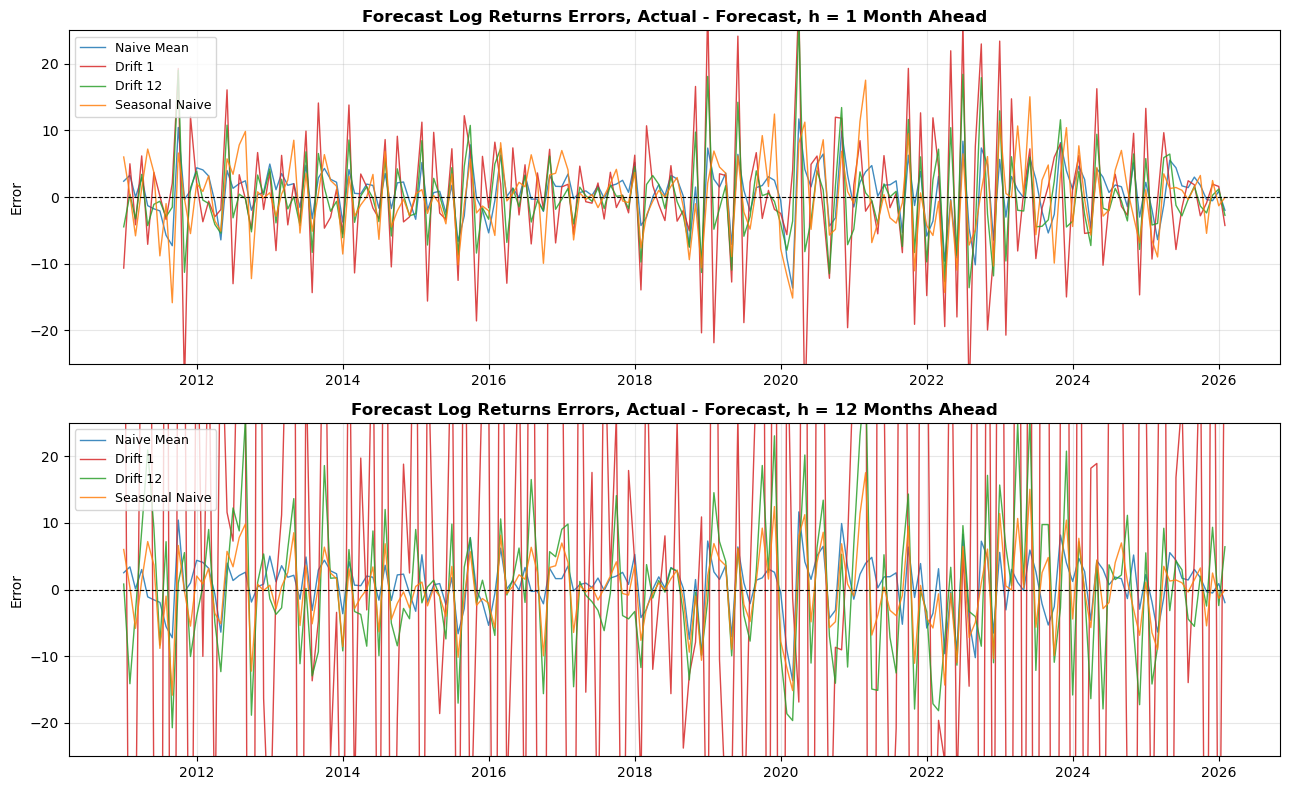

In [108]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=False)

for ax, df_fc, h_label in zip(axes,
                               [df_fc1_ret, df_fc12_ret],
                               ['h = 1 Month Ahead', 'h = 12 Months Ahead']):
    for col, lbl, c in zip(error_cols, model_labels, colors):
        ax.plot(df_fc['t_plus_h'], df_fc[col] * 100, linewidth=1.0, color=c, label=lbl, alpha=0.85)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    # Clip to keep Drift 1 from dominating at h=12.
    y_lim = max(df_fc['y_shift'].abs().max() * 100 * 1.5, 25)
    ax.set_ylim(-y_lim, y_lim)
    ax.set_title(f'Forecast Log Returns Errors, Actual - Forecast, {h_label}', fontweight='bold')
    ax.set_ylabel('Error')
    ax.legend(fontsize=9, loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Confirming the results from Question 2.1

From the plots in Question 2.2, we can see that all four models forecast values near zero. Thus, the error is approximately equal to the actual return each period. Naive Mean provides the smallest returns errors because of its simplicity, using only the mean for its predictions. Drift 1 errors are extreme at h=12 and are clipped in that log returns errors plot.